In [1]:
import pm4py
log_all = pm4py.read_xes('BPI_Challenge_2012.xes')

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

In [2]:
print(f'activities: {sorted(list(pm4py.get_event_attribute_values(log_all,"concept:name").keys()))}')

activities: ['A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED', 'A_CANCELLED', 'A_DECLINED', 'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_REGISTERED', 'A_SUBMITTED', 'O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED', 'O_SELECTED', 'O_SENT', 'O_SENT_BACK', 'W_Afhandelen leads', 'W_Beoordelen fraude', 'W_Completeren aanvraag', 'W_Nabellen incomplete dossiers', 'W_Nabellen offertes', 'W_Valideren aanvraag', 'W_Wijzigen contractgegevens']


In [3]:
# We only look at subtraces of activities starting with an 'O'.
log = pm4py.filter_event_attribute_values(
    log_all,
    "concept:name",
    ['O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED', 'O_SELECTED', 'O_SENT', 'O_SENT_BACK'],
    level="event",
    retain=True)

In [4]:
pm4py.write_xes(log, "BPI_Challenge_2012_only_O.xes")

exporting log, completed traces ::   0%|          | 0/5015 [00:00<?, ?it/s]

### Analysis

In [1]:
random_state = 2022

In [2]:
import pm4py
log = pm4py.read_xes('BPI_Challenge_2012_only_O.xes')

parsing log, completed traces ::   0%|          | 0/5015 [00:00<?, ?it/s]

The `AMOUNT_REQ` attribute is stored as a string inside the XES file. We change this in order to help all techniques capture the attribute's semantics.

In [3]:
for trace in log:
    trace.attributes['AMOUNT_REQ_NUM'] = float(trace.attributes['AMOUNT_REQ'])

In [4]:
from exdpn.petri_net import get_petri_net
net, im, fm = get_petri_net(log, miner_type='IM')

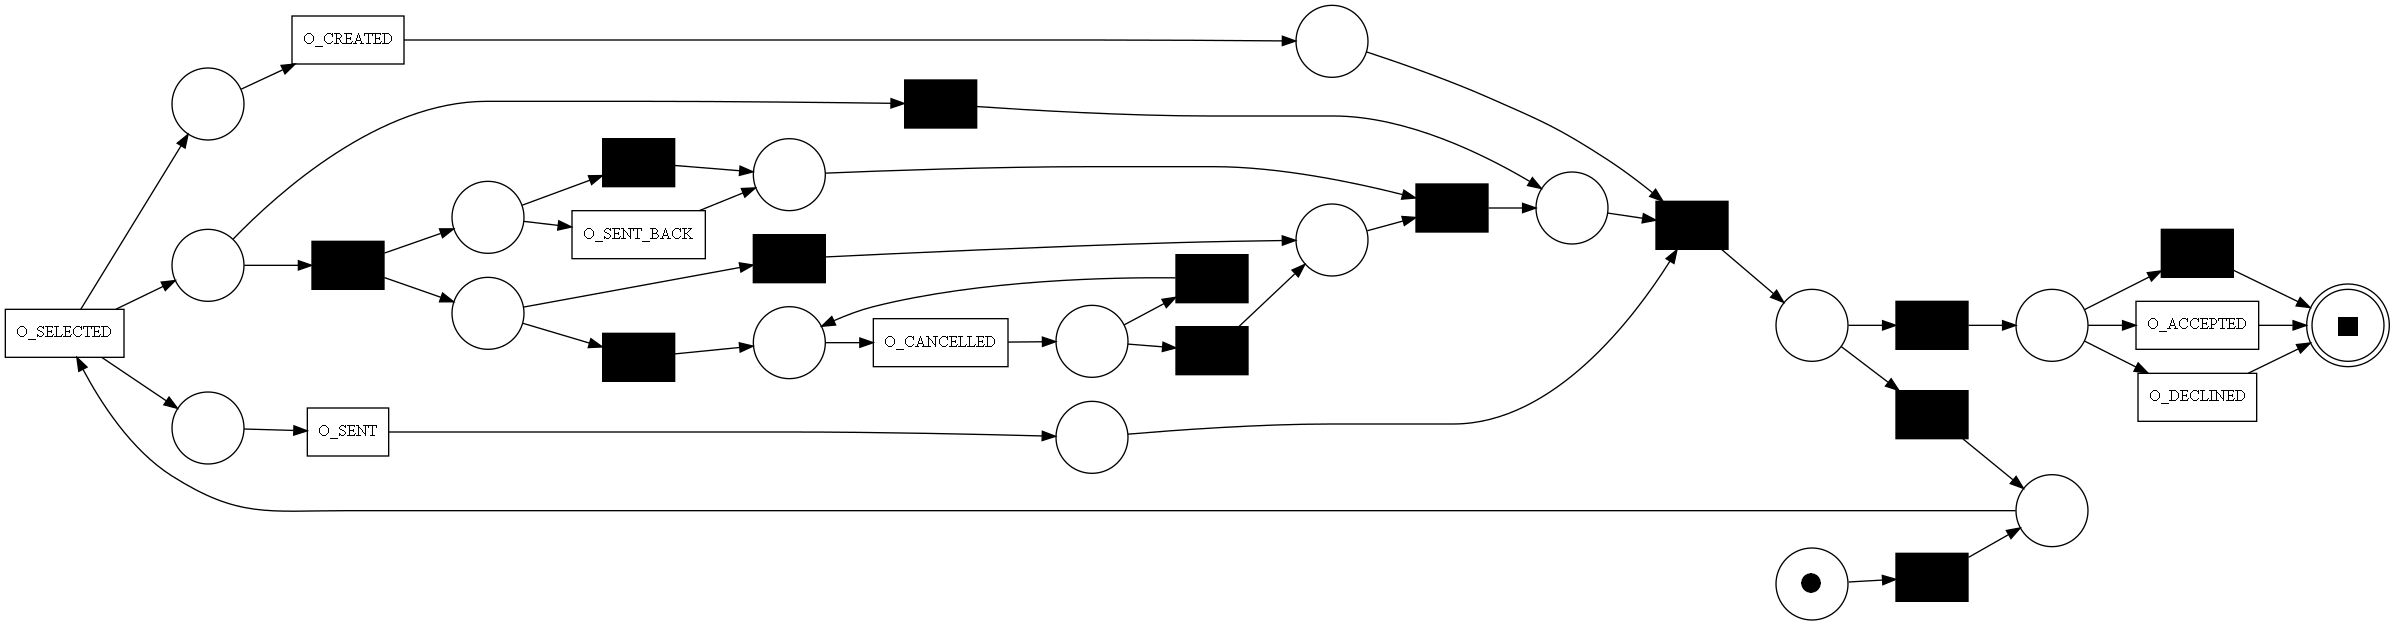

In [5]:
pm4py.view_petri_net(net, im, fm)

As we can see, we have three decision points in our log / the corresponding Petri net.
We now take all trace-level and event-level attributes that do not have ID-esque semantics:

In [6]:
event_attrs = list(pm4py.get_event_attributes(log))
trace_attrs = list(pm4py.get_trace_attributes(log))

In [7]:
trace_attrs.remove("REG_DATE")
trace_attrs.remove("AMOUNT_REQ")
trace_attrs

['AMOUNT_REQ_NUM']

In [8]:
event_attrs = [attr for attr in event_attrs if max(list(pm4py.get_event_attribute_values(log, attr).values())) != 1 and "ID" not in attr]
event_attrs.remove("time:timestamp")
event_attrs.remove("concept:name")
event_attrs

['org:resource']

Decision Trees without hyperparameter:

In [10]:
from exdpn.data_petri_net import Data_Petri_Net
from exdpn.guards import ML_Technique

ml_list = [ML_Technique.DT]

dpn = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                     event_level_attributes=event_attrs,
                     case_level_attributes=trace_attrs,
                     ml_list=ml_list, 
                     verbose=True, 
                     impute=True,
                     random_state=random_state,
                     hyperparameters={ML_Technique.DT: {}})

-> Mining guard datasets... Done
-> Evaluating guards at decision point 'p_4'... Done
-> Evaluating guards at decision point 'p_19'... Done
-> Evaluating guards at decision point 'p_6'... Done
-> Evaluating guards at decision point 'p_12'... Done
-> Evaluating guards at decision point 'p_14'... Done
-> Evaluating guards at decision point 'p_16'... Done


In [11]:
_ = dpn.get_best()

-> Best machine learning technique at decision point 'p_4': Decision Tree w/ performance 0.7417994077457964
-> Best machine learning technique at decision point 'p_19': Decision Tree w/ performance 0.9162196041235593
-> Best machine learning technique at decision point 'p_6': Decision Tree w/ performance 0.7752198910790983
-> Best machine learning technique at decision point 'p_12': Decision Tree w/ performance 0.7937287312461273
-> Best machine learning technique at decision point 'p_14': Decision Tree w/ performance 0.9615808405487251
-> Best machine learning technique at decision point 'p_16': Decision Tree w/ performance 0.9556023276116108


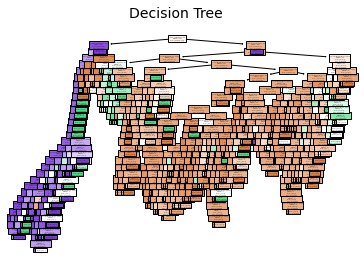

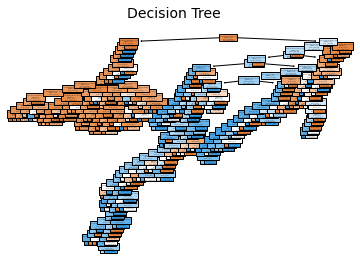

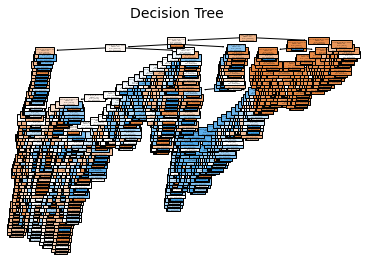

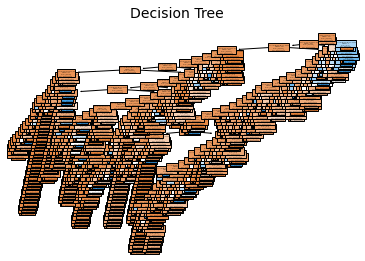

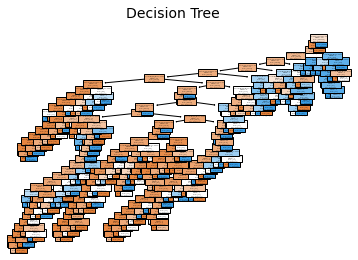

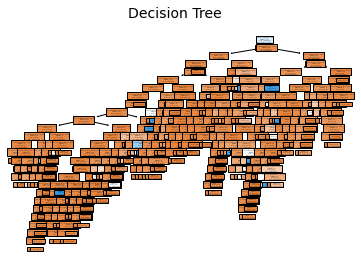

In [12]:
dps = list(dpn.decision_points)
for p in dps:
    dt_guard = dpn.guard_manager_per_place[p].guards_list[ML_Technique.DT]
    dt_explainable_representation = dt_guard.get_explainable_representation()

In a practical, live environment, we believe that a tree with a large number of splits may become less explainable due to the fact that decisions made become more complex and it becomes harder to find out which attributes had the most impact with regards to the predicted outcome. To tackle this, we have tried to find a middle ground between performance and practical explainability of decision trees by using pruning-parameters.

Data Petri Net with hyperparameter:

In [13]:
from exdpn.data_petri_net import Data_Petri_Net
from exdpn.guards import ML_Technique

ml_list = [ML_Technique.DT, ML_Technique.XGB, ML_Technique.NN, ML_Technique.LR, ML_Technique.SVM, ML_Technique.RF]

dpn = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                     event_level_attributes=event_attrs,
                     case_level_attributes=trace_attrs,
                     ml_list=ml_list, 
                     verbose=True, 
                     impute=True,
                     random_state=random_state,
                     hyperparameters={ML_Technique.NN: {'hidden_layer_sizes': (10,5), 'learning_rate_init': 0.0001, 'alpha': 0.0001, 'max_iter': 2000},
                                      ML_Technique.DT: {'min_impurity_decrease': 0.0075},
                                      ML_Technique.LR: {'C': 0.1375, 'tol': 0.001},
                                      ML_Technique.SVM: {'C': 0.3, 'tol': 0.001},
                                      ML_Technique.XGB: {'max_depth': 2, 'n_estimators': 50},
                                      ML_Technique.RF:  {'max_depth': 5}})

-> Mining guard datasets... Done
-> Evaluating guards at decision point 'p_4'... Done
-> Evaluating guards at decision point 'p_19'... Done
-> Evaluating guards at decision point 'p_6'... Done
-> Evaluating guards at decision point 'p_12'... Done
-> Evaluating guards at decision point 'p_14'... Done
-> Evaluating guards at decision point 'p_16'... Done


In [14]:
best = dpn.get_best()

-> Best machine learning technique at decision point 'p_4': Neural Network w/ performance 0.7250453351079551
-> Best machine learning technique at decision point 'p_19': Support Vector Machine w/ performance 0.941401362883408
-> Best machine learning technique at decision point 'p_6': Neural Network w/ performance 0.804848092478706
-> Best machine learning technique at decision point 'p_12': Support Vector Machine w/ performance 0.8023048368943648
-> Best machine learning technique at decision point 'p_14': Support Vector Machine w/ performance 0.9700834261398384
-> Best machine learning technique at decision point 'p_16': Decision Tree w/ performance 0.9612193113188466


In [15]:
import pandas as pd

res = pd.DataFrame(columns=["place"] + [str(ml_t for ml_t in ml_list)])

for dp,gm in dpn.guard_manager_per_place.items():
    res_row = {"place": dp} | {str(ml_t):gm.f1_mean_test[ml_t] for ml_t in gm.guards_list.keys()}
    res = res.append([res_row])
    
res['place'] = res['place'].apply(str)
res.index = res["place"]
res.drop(["place"], axis=1, inplace=True)
res.dropna(axis=1, how="all", inplace=True)

In [16]:
res.transpose()

place,p_4,p_19,p_6,p_12,p_14,p_16
Decision Tree,0.688796,0.926258,0.754484,0.795512,0.963304,0.961219
XGBoost,0.718887,0.940742,0.789721,0.800404,0.969741,0.961219
Neural Network,0.725045,0.931669,0.804848,0.795512,0.969778,0.960724
Logistic Regression,0.704031,0.939566,0.787722,0.795512,0.965321,0.961219
Support Vector Machine,0.715133,0.941401,0.779936,0.802305,0.970083,0.961219
Random Forest,0.688978,0.941183,0.758356,0.795512,0.963304,0.961219


<AxesSubplot:xlabel='place'>

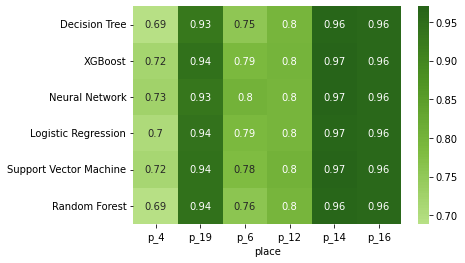

In [17]:
import seaborn as sns

sns.heatmap(res.transpose(), annot=True, cmap="PiYG", center=0.5)

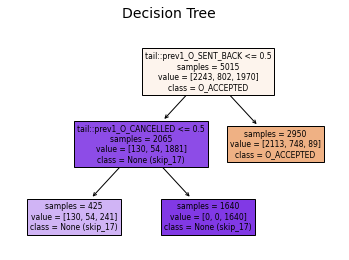

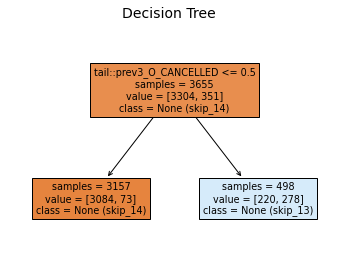

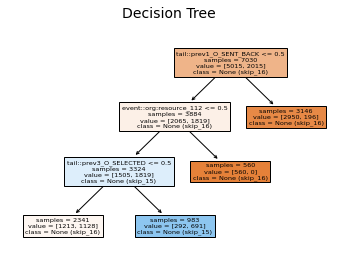

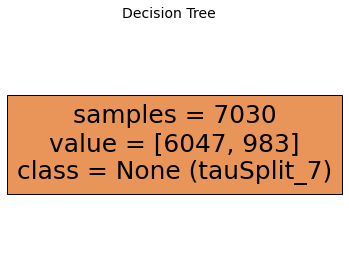

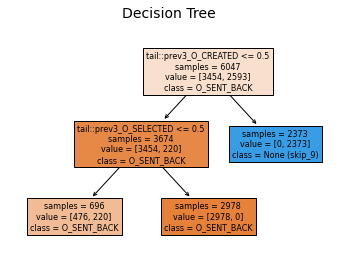

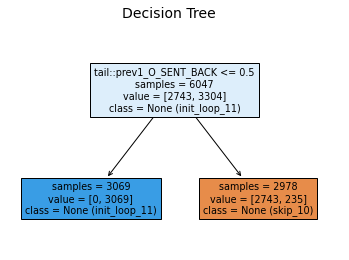

In [18]:
for _, gm in dpn.guard_manager_per_place.items():
    gm.guards_list[ML_Technique.DT].get_explainable_representation()